##### <h1 id="aa" align="center" style="color:white;background:#8B0000;padding:18px;border-radius:15px 50px; font-family:newtimeroman;"> ОБРАЩЕНИЯ И ЖАЛОБЫ ГРАЖДАН 

In [126]:
import pandas as pd
import string
import re
import pymorphy3
import pickle
import plotly.io as pio
import joblib
from wordcloud import WordCloud, STOPWORDS
from catboost import CatBoostClassifier
from collections import Counter

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from gensim.models import KeyedVectors, Word2Vec, CoherenceModel, LdaMulticore
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup as bs
from pyppeteer import launch # type: ignore

pio.renderers.default = "notebook"  
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_

True

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных </h1>

In [127]:
df = pd.read_csv("./Petitions.csv")

In [128]:
df

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


## Описание данных
* id - уникальный идентификатор жалобы
* public_petition_text - текст жалобы
* reason_category - раздел жалобы

### Парсинг

In [129]:
async def parse_city_report(page, url):
    await page.goto(url, {'waitUntil': 'networkidle2'})
    content = await page.content()
    soup = bs(content, 'html.parser')

    report_id = url.rstrip('/').split('/')[-1]

    report_type = None
    og = soup.find('meta', {'property': 'og:title'})
    if og and og.get('content'):
        parts = [p.strip() for p in og['content'].split('/')]
        if len(parts) >= 2:
            report_type = parts[1]

    user_message = None
    for msg in soup.select('div.problem-message'):
        title_el = msg.select_one('.problem-message__title')
        if title_el and title_el.get_text(strip=True).startswith('Сообщение'):
            text_div = msg.select_one('div.problem-message__text')
            if text_div:
                user_message = text_div.get_text(' ', strip=True)
            break

    return {
        'id': report_id,
        'public_petition_text': user_message,
        'reason_category': report_type
    }

In [130]:
async def brows():
    browser = await launch(headless=False, args=['--no-sandbox'], executablePath=r"C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe")
    page = await browser.newPage()

    all_reports = []
    last_page = 1
    for p in range(1, last_page + 1):
        list_url = f'https://gorod.gov.spb.ru/problems/public/?page={p}'
        await page.goto(list_url, {'waitUntil': 'networkidle2'})
        content = await page.content()
        soup = bs(content, 'html.parser')

        links = await page.evaluate('''() => {
            return Array.from(document.querySelectorAll('a[href^="/problems/"]'))
                .map(a => a.href)
                .filter(h => /^https:\\/\\/gorod\\.gov\\.spb\\.ru\\/problems\\/\\d+\\/$/.test(h));
        }''')

        # de-duplicate
        seen = set()
        unique_links = []
        for link in links:
            if link not in seen:
                seen.add(link)
                unique_links.append(link)

        # parse each problem
        for link in unique_links:
            report = await parse_city_report(page, link)
            all_reports.append(report)

    await browser.close()
    return all_reports
all_reports = await brows()
reports_df = pd.DataFrame(all_reports)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\websockets\legacy\client.py:488: DeprecationWarning:

remove loop argument

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\websockets\legacy\protocol.py:206: DeprecationWarning:

remove loop argument



In [131]:
reports_df

,id,public_petition_text,reason_category
0,6859882,Испорченная схема движения автобусов,Благоустройство
1,6859870,"Открытый канализационный люк возле школы 561, ...",Повреждения или неисправность элементов улично...
2,6859840,Неудовлетворительное содержание газонов (неско...,Благоустройство
3,6859784,Очень грязные стены в парадной на всех этажах,Содержание МКД
4,6859783,"В парадной не работает домофон, дверь закрыта,...",Содержание МКД
5,6859782,"Рыбацкий проспект 18, корпус 2, 2 секция. УК С...",Содержание МКД
6,6859781,Это что за покос травы,Благоустройство
7,6859777,"Парадная давно требует перекраски, краска на с...",Содержание МКД
8,6859774,Происходит очередная протечка канализации в по...,Водоотведение
9,6859773,Мусор внизу спуска по Корпусной,Благоустройство


In [132]:
reports_df['id'] = reports_df['id'].astype(int)

In [133]:
df = pd.concat([df, reports_df], ignore_index=True)

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Предобработка текстовых данных </h1>

In [134]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [135]:
df['public_petition_text'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(str(text).lower())))) for text in df['public_petition_text']]

df['public_petition_text'][0]

'снег на дороге'

In [136]:
russian_stopwords = stopwords.words('russian') 

def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return " ".join(tokens)

In [137]:
df['tokenize_text'] = [tokenize(text) for text in df['public_petition_text']]
df.head()

,id,public_petition_text,reason_category,tokenize_text
0,3168490,снег на дороге,Благоустройство,снег дороге
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск рекламы
2,2963920,просим убрать все деревья и кустарники которые...,Благоустройство,просим убрать деревья кустарники которые вышли...
3,3374910,неудовлетворительное состояние парадной надпис...,Содержание МКД,неудовлетворительное состояние парадной надпис...
4,3336285,граффити,Благоустройство,граффити


In [138]:
russian_stopwords = stopwords.words('russian') 

def remove_stopwords(text):
    text = [word for word in text if word not in russian_stopwords]
    return text

remove_stopwords(df['tokenize_text'])

df['tokenize_text']

0                                              снег дороге
1                         очистить кабельный киоск рекламы
2        просим убрать деревья кустарники которые вышли...
3        неудовлетворительное состояние парадной надпис...
4                                                 граффити
                               ...                        
59900    продавлен асфальт образовавшиеся дыры стекает ...
59901    лифт парадной грязный весь масле лампы постоян...
59902    асфальта работы ведутся ситуация меняется меся...
59903                             разбито стекло остановке
59904    дефект стояка отопления наблюдается коррозия с...
Name: tokenize_text, Length: 59905, dtype: object

In [139]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
        
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

df['text_stem'].head(5)

0                                           снег дорог
1                           очист кабельн киоск реклам
2    прос убра дерев кустарник котор вышл предел га...
3    неудовлетворительн состоян парадн надпис двер ...
4                                              граффит
Name: text_stem, dtype: object

In [140]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [141]:
%%time
lemm_texts_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        
df['text_lemm'] = lemm_texts_list
df['text_lemm'].head(5)

CPU times: total: 40.3 s
Wall time: 40.6 s


0                                          снег дорога
1                     очистить кабельный киоск реклама
2    просить убрать дерево кустарник который выйти ...
3    неудовлетворительный состояние парадный надпис...
4                                             граффити
Name: text_lemm, dtype: object

In [142]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;"> Облако слов лемматизированного текста </h1>

<Axes: >

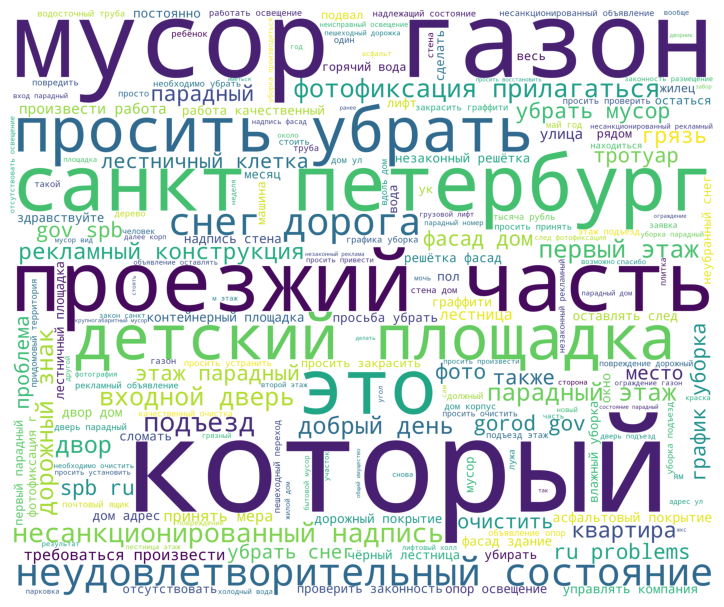

In [143]:
corpus = get_corpus(df['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;"> Облако слов стеммингованного текста </h1>

<Axes: >

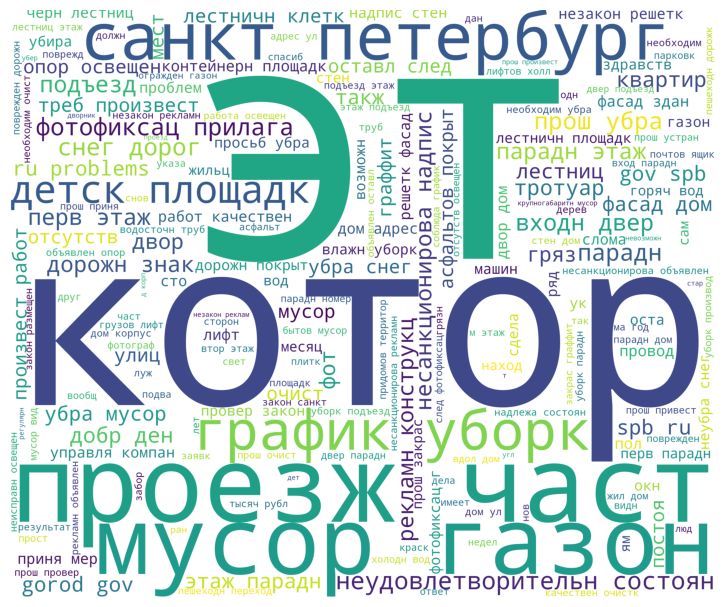

In [144]:
corpus = get_corpus(df['text_stem'].values)
procWordCloud = get_wordCloud(corpus)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;"> Тематическое моделирование </h1>

In [145]:
def tokenize2(text):
    if isinstance(text, list):  
        return text  
    if not isinstance(text, str):  
        return []  
    
    tokens = word_tokenize(text.lower(), language='russian')
    tokens = [token for token in tokens 
              if token not in russian_stopwords and len(token) >= 2]
    return tokens  

In [146]:
df['text_stem_tokenize'] = [tokenize2(text) for text in df['text_stem']]
df['text_lemm_tokenize'] = [tokenize2(text) for text in df['text_lemm']]


gensim_dictionary1 = Dictionary(df['text_lemm_tokenize'])
gensim_dictionary1.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary1.compactify()

gensim_dictionary2 = Dictionary(df['text_stem_tokenize'])
gensim_dictionary2.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary2.compactify()


corpus2 = [gensim_dictionary1.doc2bow(text) 
          for text in df['text_lemm_tokenize']]

corpus3 = [gensim_dictionary2.doc2bow(text) 
          for text in df['text_stem_tokenize']]

In [147]:
lda_20 = LdaMulticore(corpus2, num_topics=10, id2word=gensim_dictionary1, passes=10, random_state=6457)

lda_20.print_topics()

[(0,
  '0.038*"состояние" + 0.020*"площадка" + 0.019*"фасад" + 0.015*"неудовлетворительный" + 0.014*"просить" + 0.014*"привести" + 0.013*"детский" + 0.011*"дом" + 0.010*"освещение" + 0.010*"просьба"'),
 (1,
  '0.032*"рекламный" + 0.030*"фотофиксация" + 0.025*"требоваться" + 0.023*"покрытие" + 0.022*"конструкция" + 0.020*"прилагаться" + 0.019*"вода" + 0.018*"работа" + 0.018*"произвести" + 0.014*"фасад"'),
 (2,
  '0.015*"дом" + 0.013*"уборка" + 0.012*"решётка" + 0.012*"проблема" + 0.011*"фасад" + 0.010*"день" + 0.010*"фото" + 0.010*"парадный" + 0.009*"вода" + 0.009*"незаконный"'),
 (3,
  '0.075*"снег" + 0.052*"дорога" + 0.049*"убрать" + 0.030*"знак" + 0.019*"дорожный" + 0.019*"реклама" + 0.017*"очистить" + 0.015*"тротуар" + 0.014*"xx" + 0.013*"ям"'),
 (4,
  '0.015*"просить" + 0.011*"стена" + 0.011*"асфальт" + 0.009*"необходимо" + 0.009*"дом" + 0.009*"место" + 0.009*"труба" + 0.008*"подъезд" + 0.007*"ремонт" + 0.007*"тротуар"'),
 (5,
  '0.111*"надпись" + 0.038*"несанкционированный" + 0.03

In [148]:
lda_21 = LdaMulticore(corpus2, 
    num_topics=10, 
    id2word=gensim_dictionary1, 
    passes=10, random_state=6457)


vis_21 = gensimvis.prepare(lda_21, corpus2, gensim_dictionary1)

pyLDAvis.enable_notebook()

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;"> LDA для описания жалоб </h1>

In [149]:
vis_21

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.097687  0.042498       1        1  17.541532
8      0.164518  0.133568       2        1  16.373680
7     -0.121383  0.073119       3        1  11.369064
4      0.041521  0.058513       4        1  10.270084
0      0.071237  0.039960       5        1   9.324306
9     -0.229934  0.084322       6        1   8.726962
1      0.045278 -0.148939       7        1   8.197060
3     -0.186392 -0.152425       8        1   6.874423
6     -0.018884  0.045061       9        1   6.544039
5      0.136352 -0.175677      10        1   4.778851, topic_info=         Term         Freq        Total Category  logprob  loglift
55      мусор  8984.000000  8984.000000  Default  30.0000  30.0000
24    надпись  4664.000000  4664.000000  Default  29.0000  29.0000
1        снег  3324.000000  3324.000000  Default  28.0000  28.0000
20     убрать  5145.000000  5145.000000  Default  27.0000  27.0000
28       этаж  7853.000000  7853.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
9         дом   229.572059  8377.378995  Topic10  -4.7685  -0.5561
54     уборка   200.825683  4556.047543  Topic10  -4.9023  -0.0808
18    просить   174.228283  6536.133356  Topic10  -5.0444  -0.5838
194     район   159.069693   800.571537  Topic10  -5.1354   1.4250
26   парадный   163.036140  8507.491268  Topic10  -5.1108  -0.9138

[754 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
845       1  0.001444  gorod
845       2  0.001444  gorod
845       4  0.002887  gorod
845       6  0.980139  gorod
845       8  0.001444  gorod
...     ...       ...    ...
87        8  0.003534   ящик
87        9  0.065381   ящик
87       10  0.008835   ящик
2209      1  0.014610     №№
2209      3  0.978866     №№

[3782 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 8, 5, 1, 10, 2, 4, 7, 6])

<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Оценка CoherenceModel </h1>

In [150]:
coherence_model = CoherenceModel(model=lda_20,
    texts=df['text_lemm_tokenize'],
    dictionary=gensim_dictionary1,
    coherence="c_v")

coherence_value = coherence_model.get_coherence()

print(f"Когерентность модели: {coherence_value}")

Когерентность модели: 0.47168743446880745


<h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Векторизация </h1>

In [151]:
vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

print(vectorizer.vocabulary_)

{'снег': 13741, 'дорога': 3245, 'очистить': 9303, 'кабельный': 4831, 'киоск': 5100, 'реклама': 12778, 'просить': 11902, 'убрать': 15214, 'дерево': 2942, 'кустарник': 5808, 'который': 5573, 'выйти': 2030, 'предел': 11086, 'газон': 2315, 'пешеходный': 9869, 'зона': 4414, 'начинать': 7322, 'подъезд': 10390, 'фасад': 15715, 'дом': 3196, 'сторона': 14351, 'ул': 15376, 'наличный': 7088, 'неудовлетворительный': 7842, 'состояние': 13989, 'парадный': 9415, 'надпись': 6994, 'дверь': 2811, 'этаж': 16692, 'граффити': 2640, 'необходимо': 7588, 'проверить': 11600, 'законность': 3883, 'установка': 15543, 'вывеска': 1954, 'мкд': 6602, 'адрес': 319, 'проспект': 11916, 'непокорённый': 7662, 'случай': 13644, 'установить': 15541, 'незаконно': 7463, 'её': 3497, 'демонтировать': 2922, 'уборка': 15204, 'производиться': 11746, 'лестница': 5978, 'очень': 9295, 'грязно': 2717, 'вплоть': 1780, 'го': 2500, 'звонок': 4333, 'жкс': 3612, 'дать': 2793, 'результат': 12768, 'мусор': 6812, 'отсутствовать': 9203, 'освеще

In [152]:
vectorizer.get_feature_names_out()[10:20]

array(['bceybla', 'be', 'bece', 'bf', 'bfn', 'birthday', 'bobcar',
       'bocejcxxebxcpxkvkvtc', 'cab', 'card'], dtype=object)

In [153]:
def text_to_vector(text, model):
    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [154]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)

df['text_lemm_str'] = df['text_lemm_tokenize'].apply(' '.join)
df['text_stem_str'] = df['text_stem_tokenize'].apply(' '.join)

count_matrix_lemm = vectorizer.fit_transform(df['text_lemm_str'])
count_matrix_stem = vectorizer.fit_transform(df['text_stem_str'])


count_matrix_lemm.shape

(59905, 98558)

In [155]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,min_df=0.01, stop_words=russian_stopwords,
    ngram_range=(1,3))


tfidf_matrix_lemm = tfidf_vectorizer.fit_transform(df['text_lemm_str'])
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(df['text_stem_str'])

In [156]:
label_encoder = LabelEncoder()
df['cluster'] = label_encoder.fit_transform(df['reason_category'])
df

,id,public_petition_text,reason_category,tokenize_text,text_stem,text_lemm,text_stem_tokenize,text_lemm_tokenize,text_lemm_str,text_stem_str,cluster
0,3168490,снег на дороге,Благоустройство,снег дороге,снег дорог,снег дорога,"[снег, дорог]","[снег, дорога]",снег дорога,снег дорог,0
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск рекламы,очист кабельн киоск реклам,очистить кабельный киоск реклама,"[очист, кабельн, киоск, реклам]","[очистить, кабельный, киоск, реклама]",очистить кабельный киоск реклама,очист кабельн киоск реклам,0
2,2963920,просим убрать все деревья и кустарники которые...,Благоустройство,просим убрать деревья кустарники которые вышли...,прос убра дерев кустарник котор вышл предел га...,просить убрать дерево кустарник который выйти ...,"[прос, убра, дерев, кустарник, котор, вышл, пр...","[просить, убрать, дерево, кустарник, который, ...",просить убрать дерево кустарник который выйти ...,прос убра дерев кустарник котор вышл предел га...,0
3,3374910,неудовлетворительное состояние парадной надпис...,Содержание МКД,неудовлетворительное состояние парадной надпис...,неудовлетворительн состоян парадн надпис двер ...,неудовлетворительный состояние парадный надпис...,"[неудовлетворительн, состоян, парадн, надпис, ...","[неудовлетворительный, состояние, парадный, на...",неудовлетворительный состояние парадный надпис...,неудовлетворительн состоян парадн надпис двер ...,11
4,3336285,граффити,Благоустройство,граффити,граффит,граффити,[граффит],[граффити],граффити,граффит,0
...,...,...,...,...,...,...,...,...,...,...,...
59900,6859768,продавлен асфальт в образовавшиеся дыры стекае...,Благоустройство,продавлен асфальт образовавшиеся дыры стекает ...,продавл асфальт образова дыр стека вод размыва...,продавить асфальт образоваться дыра стекать во...,"[продавл, асфальт, образова, дыр, стека, вод, ...","[продавить, асфальт, образоваться, дыра, стека...",продавить асфальт образоваться дыра стекать во...,продавл асфальт образова дыр стека вод размыва...,0
59901,6859767,лифт в парадной грязный и весь в масле с лампы...,Содержание МКД,лифт парадной грязный весь масле лампы постоян...,лифт парадн грязн ве масл ламп постоя капа маш...,лифт парадный грязный весь масло лампа постоян...,"[лифт, парадн, грязн, ве, масл, ламп, постоя, ...","[лифт, парадный, грязный, весь, масло, лампа, ...",лифт парадный грязный весь масло лампа постоян...,лифт парадн грязн ве масл ламп постоя капа маш...,11
59902,6859765,нет асфальта работы не ведутся ситуация не мен...,Благоустройство,асфальта работы ведутся ситуация меняется меся...,асфальт работ ведут ситуац меня месяц всем тро...,асфальт работа вестись ситуация меняться месяц...,"[асфальт, работ, ведут, ситуац, месяц, всем, т...","[асфальт, работа, вестись, ситуация, меняться,...",асфальт работа вестись ситуация меняться месяц...,асфальт работ ведут ситуац месяц всем тротуар ...,0
59903,6859764,разбито стекло на остановке,Благоустройство,разбито стекло остановке,разбит стекл остановк,разбитый стекло остановка,"[разбит, стекл, остановк]","[разбитый, стекло, остановка]",разбитый стекло остановка,разбит стекл остановк,0


In [157]:
cluster_to_reason = {
    cluster: reason for cluster, reason in zip(
        label_encoder.transform(label_encoder.classes_), 
        label_encoder.classes_
    )
}

print(cluster_to_reason)

{0: 'Благоустройство', 1: 'Водоотведение', 2: 'Водоснабжение', 3: 'Кровля', 4: 'Нарушение порядка пользования общим имуществом', 5: 'Нарушение правил пользования общим имуществом', 6: 'Незаконная информационная и (или) рекламная конструкция', 7: 'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)', 8: 'Повреждения или неисправность элементов уличной инфраструктуры', 9: 'Подвалы', 10: 'Санитарное состояние', 11: 'Содержание МКД', 12: 'Состояние рекламных или информационных конструкций', 13: 'Фасад', 14: 'Центральное отопление'}


In [158]:
X = tfidf_vectorizer.fit_transform(df['text_lemm'])
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [159]:
def fun_punctuation_text(text):
    text = text.lower()
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    text = ''.join([i if not i.isdigit() else '' for i in text])
    text = ''.join([i if i.isalpha() else ' ' for i in text])
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('[a-z]', '', text, flags=re.I)
    st = '❯\xa0'
    text = ''.join([ch if ch not in st else ' ' for ch in text])
    return text

def fun_lemmatizing_text(text):
    tokens = word_tokenize(text)
    res = list()
    for word in tokens:
        p = pymorphy3.MorphAnalyzer(lang='ru').parse(word)[0]
        res.append(p.normal_form)  
    text = " ".join(res)
    return text

def fun_tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text



def processing(text):
    text = fun_punctuation_text(text)
    text = fun_lemmatizing_text(text)
    text= fun_tokenize(text)
    text_vectorized = tfidf_vectorizer.transform([text]) 
    return text_vectorized.toarray()

In [160]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.8450880560888073
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6955
           1       0.48      0.25      0.33        48
           2       0.72      0.75      0.73       162
           3       0.56      0.35      0.43       165
           4       0.53      0.35      0.42        49
           5       0.83      0.68      0.74       434
           6       0.88      0.72      0.79       366
           7       0.69      0.40      0.51        50
           8       0.84      0.68      0.75       233
           9       0.47      0.43      0.45        51
          10       0.47      0.23      0.31        87
          11       0.85      0.80      0.82      2893
          12       0.81      0.33      0.47       134
          13       0.69      0.46      0.55       297
          14       0.18      0.04      0.06        57

    accuracy                           0.85     11981
   macro avg       0.66      0.49      0.55    

In [161]:
print(knn.predict(processing("Вода")))
print(knn.predict_proba(processing("Вода")))

[2]
[[0.2 0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


In [162]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8667056172272766
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      6955
           1       0.57      0.17      0.26        48
           2       0.79      0.74      0.77       162
           3       0.60      0.41      0.49       165
           4       0.63      0.35      0.45        49
           5       0.85      0.71      0.78       434
           6       0.92      0.76      0.83       366
           7       0.75      0.42      0.54        50
           8       0.91      0.69      0.79       233
           9       0.54      0.49      0.52        51
          10       0.61      0.22      0.32        87
          11       0.85      0.85      0.85      2893
          12       0.85      0.38      0.53       134
          13       0.74      0.52      0.61       297
          14       0.33      0.04      0.06        57

    accuracy                           0.87     11981
   macro avg       0.72      0.51    

In [163]:
print(rf.predict(processing("Реклама")))
print(rf.predict_proba(processing("Реклама")))

[0]
[[0.5730246  0.         0.         0.         0.         0.
  0.30551364 0.         0.         0.         0.         0.01063428
  0.11082748 0.         0.        ]]


In [164]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)
y_pred_gnb = gnb.predict(X_test_dense)

print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb))

Gaussian Naive Bayes Accuracy: 0.2684250062599115
              precision    recall  f1-score   support

           0       0.97      0.25      0.39      6955
           1       0.06      0.33      0.10        48
           2       0.10      0.06      0.08       162
           3       0.06      0.12      0.08       165
           4       0.07      0.73      0.12        49
           5       0.79      0.44      0.57       434
           6       0.25      0.17      0.20       366
           7       0.03      0.90      0.06        50
           8       0.12      0.73      0.21       233
           9       0.04      0.76      0.07        51
          10       0.02      0.16      0.03        87
          11       0.81      0.24      0.37      2893
          12       0.08      0.84      0.14       134
          13       0.13      0.18      0.15       297
          14       0.03      0.63      0.06        57

    accuracy                           0.27     11981
   macro avg       0.24      0

In [165]:
print(gnb.predict(processing("Вода")))
print(gnb.predict_proba(processing("Вода")))

[1]
[[0.00000000e+000 1.00000000e+000 6.17228678e-058 2.77374220e-132
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  8.41285658e-112 1.39012620e-042 0.00000000e+000 0.00000000e+000
  0.00000000e+000 6.93062990e-190 1.99387500e-012]]


In [166]:
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



Logistic Regression Accuracy: 0.8574409481679326
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6955
           1       0.70      0.29      0.41        48
           2       0.78      0.71      0.74       162
           3       0.64      0.33      0.44       165
           4       0.81      0.27      0.40        49
           5       0.85      0.70      0.77       434
           6       0.89      0.73      0.80       366
           7       0.91      0.20      0.33        50
           8       0.90      0.68      0.77       233
           9       0.61      0.49      0.54        51
          10       0.56      0.23      0.33        87
          11       0.85      0.85      0.85      2893
          12       0.85      0.30      0.44       134
          13       0.66      0.48      0.56       297
          14       0.00      0.00      0.00        57

    accuracy                           0.86     11981
   macro avg       0.73      0.

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [167]:
print(lr.predict(processing("Вода")))
print(lr.predict_proba(processing("Вода")))

[2]
[[4.09547478e-02 6.08429376e-03 9.18533140e-01 2.19308917e-02
  1.01540046e-04 1.32405229e-03 6.71796480e-04 6.27274841e-04
  1.48231202e-03 2.21910340e-04 1.00976040e-04 9.57845439e-04
  5.38431247e-04 5.28793554e-03 1.18285284e-03]]


In [171]:
def preprocess_list(X):
    return [fun_pred_text(text) for text in X]

In [173]:
pipe = Pipeline([
    ("preprocessor", FunctionTransformer(preprocess_list, validate=False)),
    ("vectorizer",   vectorizer),
    ("classifier",   rf)
])

In [174]:
with open('model_knn1.pkl', 'wb') as f:
    pickle.dump(rf, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open("pipeline.pkl", "wb") as f:
    pickle.dump(pipe, f)